In [ ]:
''' Optional step:  To mount and use files in Google Drive'''
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
import datetime
import numpy as np
import pandas as pd
from math import exp
import torch.nn as nn
from random import random
from math import log as ln
from scipy.stats import norm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from csv import writer as csvwriter
from torch.utils.data import DataLoader, Dataset
from sklearn.linear_model import LinearRegression

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


In [ ]:
trainFile   = "/content/drive/My Drive/Workflow/generatedTrainData.csv"
valFile     = "/content/drive/My Drive/Workflow/generatedValData.csv"
iTrainFile = "/content/drive/My Drive/Workflow/inverseTrainData.csv"
iValFile = "/content/drive/My Drive/Workflow/inverseValData.csv"
pTrainFile = "/content/drive/My Drive/Workflow/predictionTrainData.csv"
pValFile = "/content/drive/My Drive/Workflow/predictionValData.csv"

mdFile = "/content/drive/My Drive/Workflow/MarketData.csv"
valPredictionPath = "/content/drive/My Drive/Workflow/cannVal.csv"
trainPredictionPath = "/content/drive/My Drive/Workflow/cannTrain.csv"

totalSize = 30000

'''
Stock price by Strike price (S) 0.6   - 1.4
Maturity                    (T) 1 day - 3 years
Risk free rate              (r) 1%    - 7%
Volatility                  (σ) 2%    - 90%
Hurst Parameter             (H) 0     - 1            
'''

randSbyK = lambda : 0.6 + random()*0.8
randK = lambda : random()
randτ = lambda : 1/365 + random()*1094/365
randR = lambda : 0.01 + random()*0.06
randσ = lambda : 0.02 + random()*0.88
randH = lambda : random()

In [ ]:
Φ = norm.cdf
columns = ["S","K","r","τ","σ","H","C"]

d1 = lambda S,K,r,τ,σ,H : (ln(S/K) + r*τ + 0.5*(σ**2)*(τ**(2*H)))/(σ*(τ**H))

d2 = lambda S,K,r,τ,σ,H : d1(S,K,r,τ,σ,H) - σ*(τ**H)

def Cf(S,K,r,τ,σ,H):    
  ''' fractional Black-Scholes value of a European call option '''
  return S*Φ(d1(S,K,r,τ,σ,H)) - (K*exp(-r*τ))*Φ(d2(S,K,r,τ,σ,H))

In [ ]:
def createData( dataSize ):
  ''' Create <dataSize> number of fBSM entries in the <dataFile> '''
  i, data = 0, np.zeros((dataSize,7))
  while i < dataSize:
    SbyK,K,r,τ,σ,H = randSbyK(),randK(),randR(),randτ(),randσ(),randH()
    S = SbyK*K
    C = Cf(S,K,r,τ,σ,H)
    if C < 0.1: continue
    data[i,:] = [S,K,r,τ,σ,H,C]
    i += 1
  return data

def computeInverseOutput( data ):
  ''' Create στ^H from the data value '''
  return data[:,-3]*(data[:,-4]**data[:,-2])

def createDataFile( dataFile, data, header=None ):
  ''' Create <dataSize> number of fBSM entries in the <dataFile> '''
  pd.DataFrame(data).to_csv(dataFile, header = header or columns, index = None)
  print(f"File <{dataFile}> created with {len(data)} entries")

In [ ]:
data = createData( totalSize )
inverseData = computeInverseOutput( data )
iMean, iStd = inverseData.mean(), inverseData.std()
normInverseData = (inverseData - iMean)/iStd
minInverse = min(normInverseData)
means = np.array(list(map(lambda i: data[:,i].mean(), range(0,7))))
stds = np.array(list(map(lambda i: data[:,i].std(), range(0,7))))
normData = (data - means)/stds
minCost = min(normData[:,-1]) 
normData[:,-1] = normData[:,-1] - minCost - 0.5
normInverseData = normInverseData - minInverse - 0.5

In [ ]:
print(minInverse)
print(minCost)
print(means)
print(stds)
print(iMean, iStd)

# Statistics

[S,K,r,τ,σ,H,C]

**Inverse output (στ<sup>H</sup>) <br>**
μ: 0.6039890110123125 <br>
σ: 0.3986395125288202 <br>

**Means of various inputs: <br>**
[0.54902774 0.53220327 0.04021916 1.57032268 0.49354565 0.49878177
 0.15630499]

**Standard deviations of various inputs: <br>**
[0.30926215 0.27354582 0.01731955 0.84257395 0.24492725 0.28943645
 0.13603969]

**Minimum Cost: <br>**
-1.0754482995211179

**Minimum Inverse: <br>**
-1.51383233733901

In [ ]:
split = int(0.8*totalSize)
createDataFile( trainFile, normData[:split])
createDataFile( valFile, normData[split:])
createDataFile( iTrainFile,normInverseData[:split],header=["στ^H"])
createDataFile( iValFile,normInverseData[split:],header=["στ^H"])

File </content/drive/My Drive/Workflow/generatedTrainData.csv> created with 24000 entries
File </content/drive/My Drive/Workflow/generatedValData.csv> created with 6000 entries
File </content/drive/My Drive/Workflow/inverseTrainData.csv> created with 24000 entries
File </content/drive/My Drive/Workflow/inverseValData.csv> created with 6000 entries


In [ ]:
class fBMDataset(Dataset):
    
    def __init__(self, file_path):
        self.data = pd.read_csv(file_path)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-1].values).float()
        Y = torch.tensor([item[-1]]).float()
        return X, Y

In [ ]:
trainDataSet = fBMDataset(trainFile)
valDataSet = fBMDataset(valFile)

In [ ]:
def logModelDetails(model):
  ''' log a Pytorch model specs '''
  print(model)
  params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print(f"Total trainable paramters: {params}")

class Pricer (nn.Module):
  ''' The pricer neural network functional '''

  def __init__(self,inLength,outLength):
    super().__init__()
    self.fc1 = nn.Linear(inLength,128) 
    self.fc2 = nn.Linear(128, 128)
    self.fc3 = nn.Linear(128, 128)
    self.final = nn.Linear(128,outLength)

  def forward(self, x):
    out = self.fc1(x)
    out = F.dropout(out, p = 0.2)
    out = F.gelu(self.fc2(out))
    out = F.dropout(out, p = 0.2)
    out = F.gelu(self.fc3(out))
    out = F.dropout(out, p = 0.2)
    out = F.softplus(self.final(out)) - 0.5
    return out

In [ ]:
def validate(model, val_loader, loss_fn):
  ''' Method which accepts the model as well as train and validation data loaders and logs the accuracy '''
  loss_val = 0.0
  with torch.no_grad():
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.float().to(device=device)        
      outputs = model(Xs)
      loss_val += loss_fn(outputs, Ys.view(-1,1)).item()
  print(f"Validation Loss {round(loss_val/len(val_loader),5)}")

In [ ]:
def pf(x, λ, m):
  ''' Penalty function for applying soft constraints of no arbitrage conditions '''
  fn = λ*(x**m)
  return fn*(fn>0)

def penalty(outputs,Ys,Xs,λ, m):
  ''' Total penalty to be added to the cost function '''
  dCdx = torch.autograd.grad(outputs, Xs, grad_outputs=outputs.data.new(outputs.shape).fill_(1), create_graph=True, retain_graph=True)[0]
  d2Cdx2 = torch.autograd.grad(dCdx, Xs, grad_outputs=dCdx.data.new(dCdx.shape).fill_(1), create_graph=True, retain_graph=True)[0]
  K, T = Xs[:,1], Xs[:,3]
  dCdk, dCdt = dCdx[:,1], dCdx[:,3]
  d2Cdk2 = d2Cdx2[:,1]
  return torch.sum(pf(-(K**2)*(d2Cdk2),λ, m)) + torch.sum(pf(-T*dCdt,λ, m)) + torch.sum(pf(K*dCdk,λ, m))

def training_loop_penalty(n_epochs, optimizer, model, loss_fn, train_loader, val_loader, λ=0.05, m=3):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Variable(Xs.to(device=device), requires_grad=True)
      Ys = Variable(Ys.to(device=device), requires_grad=True)
      outputs = model(Xs)
      lf = loss_fn(outputs, Ys)
      pf = penalty(outputs,Ys,Xs,λ, m)
      loss = lf + pf
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    validate(model, val_loader, loss_fn)

In [ ]:
def getTrainAndValOutputs( model, train_loader, val_loader ):
  yActualTrain, yActualVal = np.zeros(24000), np.zeros(6000)
  yPredTrain, yPredVal = np.zeros(24000), np.zeros(6000)
  with torch.no_grad():
    model.eval()
    i = 0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      yPredTrain[i:i+len(Ys)] = model(Xs).numpy().flatten()
      yActualTrain[i:i+len(Ys)] = Ys.numpy().flatten()
      i += len(Ys)
    i = 0
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      yPredVal[i:i+len(Ys)] = model(Xs).numpy().flatten()
      yActualVal[i:i+len(Ys)] = Ys.numpy().flatten()
      i += len(Ys)
  model.train()
  return yActualTrain, yActualVal, yPredTrain, yPredVal

def plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal):
  ''' Plot both train and validation predictions '''
  plt.figure(figsize=(21, 6))
  plt.subplot(131)
  plt.scatter(yActualTrain, yPredTrain, s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("In sample")
  plt.subplot(132)
  plt.scatter(yActualVal,yPredVal, s=1)
  plt.xlabel("Actual Values")
  plt.ylabel("Predicted Values")
  plt.title("Out of sample")
  plt.show()

In [ ]:
model = Pricer(6,1).to(device=device)
logModelDetails(model)
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= True)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= True)

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 34049


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

In [ ]:
training_loop_penalty (
  n_epochs = 2,
  optimizer = optimizer,
  model = model,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader
  )

2020-08-02 07:35:36.541681 Epoch 1 
Training Loss 0.04835
Validation Loss 0.04226
2020-08-02 07:35:50.053007 Epoch 2 
Training Loss 0.04889
Validation Loss 0.04326


In [ ]:
#torch.save(model.state_dict(), "/content/drive/My Drive/Workflow/Pricing/Epoch_34.pt")
model.load_state_dict(torch.load("/content/drive/My Drive/Workflow/Pricing/Epoch_34.pt", map_location=device))

<All keys matched successfully>

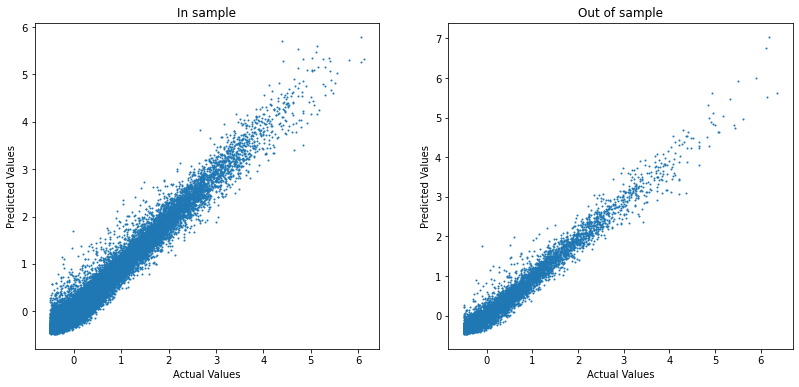

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
model_np = Pricer(6,1).to(device=device)
logModelDetails(model_np)

Pricer(
  (fc1): Linear(in_features=6, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 34049


In [ ]:
optimizer = torch.optim.Adam(model_np.parameters(), lr=1e-4)

In [ ]:
training_loop_penalty (
  n_epochs = 4,
  optimizer = optimizer,
  model = model_np,
  loss_fn = loss_fn,
  train_loader = trainLoader,
  val_loader = valLoader,
  λ = 0
  )

2020-08-02 08:03:26.072424 Epoch 1 
Training Loss 0.01736
Validation Loss 0.01925
2020-08-02 08:03:39.250275 Epoch 2 
Training Loss 0.01769
Validation Loss 0.01737
2020-08-02 08:03:52.487789 Epoch 3 
Training Loss 0.01718
Validation Loss 0.01818
2020-08-02 08:04:05.732626 Epoch 4 
Training Loss 0.01744
Validation Loss 0.01832


In [ ]:
torch.save(model.state_dict(), "/content/drive/My Drive/Workflow/Pricing/np_Epoch_40.pt")
#model.load_state_dict(torch.load("/content/drive/My Drive/Workflow/Pricing/np_Epoch_34.pt", map_location=device))

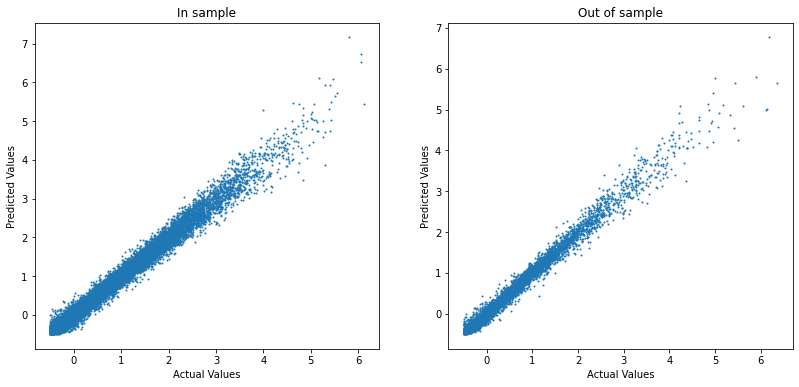

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( model_np, trainLoader, valLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
class fBMDatasetInverse(Dataset):
    
    def __init__(self, data_path, inverse_path ):
        self.data = pd.read_csv(data_path)
        self.inverse = pd.read_csv(inverse_path)
        self.data = self.data[["C","S","r","K","τ","σ","H"]]
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item[:-2].values).float()
        Y = torch.tensor(self.inverse.iloc[index]).float()
        return X, Y

In [ ]:
iTrainDataSet = fBMDatasetInverse(trainFile,iTrainFile)
iValDataSet = fBMDatasetInverse(valFile,iValFile)

In [ ]:
def iValidate(model, val_loader, loss_fn):
  ''' Method which accepts the model as well as train and validation data loaders and logs the accuracy '''
  loss_val = 0.0
  with torch.no_grad():
    for Xs, Ys in val_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.to(device=device)        
      outputs = model(Xs)
      loss_val += loss_fn(outputs, Ys).item()
  print(f"Validation Loss {round(loss_val/len(val_loader),5)}")

def i_training_loop(n_epochs, optimizer, model, loss_fn, train_loader, val_loader):
  ''' Method to execute the training '''
  for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for Xs, Ys in train_loader:
      Xs = Xs.to(device=device)
      Ys = Ys.to(device=device)
      outputs = model(Xs)
      loss = loss_fn(outputs, Ys)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_train += loss.item()
    print(f'{datetime.datetime.now()} Epoch {epoch} \nTraining Loss {round(loss_train/len(train_loader),5)}')
    iValidate(model, val_loader, loss_fn)

In [ ]:
iModel = Pricer(5,1).to(device=device)
logModelDetails(iModel)

Pricer(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 33921


In [ ]:
iTrainLoader = torch.utils.data.DataLoader(iTrainDataSet, 64, shuffle= True)
iValLoader = torch.utils.data.DataLoader(iValDataSet, 64, shuffle= True)
optimizer = torch.optim.Adam(iModel.parameters(), lr=1e-6)
loss_fn = nn.MSELoss()

In [ ]:
#torch.save(iModel.state_dict(), "/content/drive/My Drive/Workflow/Inverse/Epoch_20.pt")
iModel.load_state_dict(torch.load("/content/drive/My Drive/Workflow/Inverse/Epoch_20.pt", map_location=device))

<All keys matched successfully>

In [ ]:
i_training_loop(
  n_epochs = 4,
  optimizer = optimizer,
  model = iModel,
  loss_fn = loss_fn,
  train_loader = iTrainLoader,
  val_loader = iValLoader,
  )

2020-08-09 11:52:30.168850 Epoch 1 
Training Loss 0.03395
Validation Loss 0.03408
2020-08-09 11:52:50.429289 Epoch 2 
Training Loss 0.03503
Validation Loss 0.03632
2020-08-09 11:53:10.749353 Epoch 3 
Training Loss 0.03431
Validation Loss 0.03743
2020-08-09 11:53:30.658485 Epoch 4 
Training Loss 0.03482
Validation Loss 0.03758


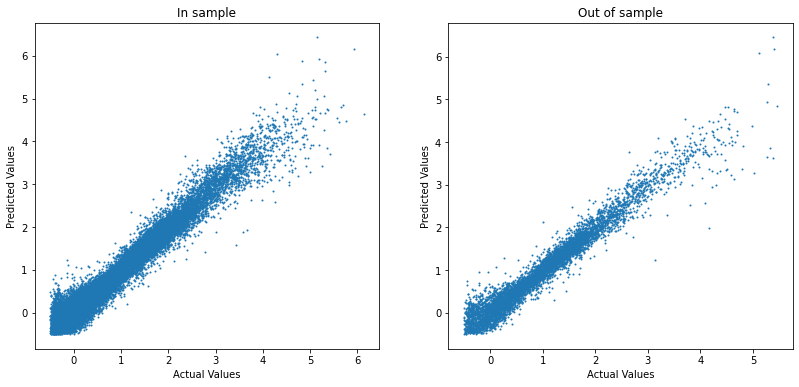

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( iModel, iTrainLoader, iValLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
trainLoader = torch.utils.data.DataLoader(trainDataSet, 64, shuffle= False)
valLoader = torch.utils.data.DataLoader(valDataSet, 64, shuffle= False)
_, _, yPredTrain, yPredVal = getTrainAndValOutputs( model, trainLoader, valLoader)

pd.DataFrame(yPredTrain).to_csv(trainPredictionPath, header = ["Cann"], index = None)
pd.DataFrame(yPredVal).to_csv(valPredictionPath, header = ["Cann"], index = None)

In [ ]:
class fBMDatasetInverseChain(Dataset):
    
    def __init__(self, data_path, cann_path, inverse_path ):
        original = pd.read_csv(data_path)[["S","r","K","τ"]]
        cann = pd.read_csv(cann_path)
        self.inverse = pd.read_csv(inverse_path)
        self.data = pd.concat([cann, original], axis=1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item.values).float()
        Y = torch.tensor(self.inverse.iloc[index]).float()
        return X, Y

In [ ]:
icTrainDataSet = fBMDatasetInverseChain(trainFile,trainPredictionPath,iTrainFile)
icValDataSet = fBMDatasetInverseChain(valFile,valPredictionPath,iValFile)

In [ ]:
icModel = Pricer(5,1).to(device=device)
logModelDetails(icModel)

Pricer(
  (fc1): Linear(in_features=5, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=128, bias=True)
  (final): Linear(in_features=128, out_features=1, bias=True)
)
Total trainable paramters: 33921


In [ ]:
icTrainLoader = torch.utils.data.DataLoader(icTrainDataSet, 64, shuffle= True)
icValLoader = torch.utils.data.DataLoader(icValDataSet, 64, shuffle= True)
loss_fn = nn.MSELoss()

In [ ]:
optimizer = torch.optim.Adam(icModel.parameters(), lr=1e-5)

In [ ]:
i_training_loop(
  n_epochs = 4,
  optimizer = optimizer,
  model = icModel,
  loss_fn = loss_fn,
  train_loader = icTrainLoader,
  val_loader = icValLoader,
  )

2020-08-09 12:43:25.063808 Epoch 1 
Training Loss 0.12527
Validation Loss 0.13809
2020-08-09 12:43:41.359324 Epoch 2 
Training Loss 0.12416
Validation Loss 0.13872
2020-08-09 12:43:57.710341 Epoch 3 
Training Loss 0.12479
Validation Loss 0.13754
2020-08-09 12:44:14.012481 Epoch 4 
Training Loss 0.12681
Validation Loss 0.13749


In [ ]:
torch.save(icModel.state_dict(), "/content/drive/My Drive/Workflow/InverseC/Epoch_12.pt")
#icModel.load_state_dict(torch.load("/content/drive/My Drive/Workflow/InverseC/Epoch_20.pt", map_location=device))

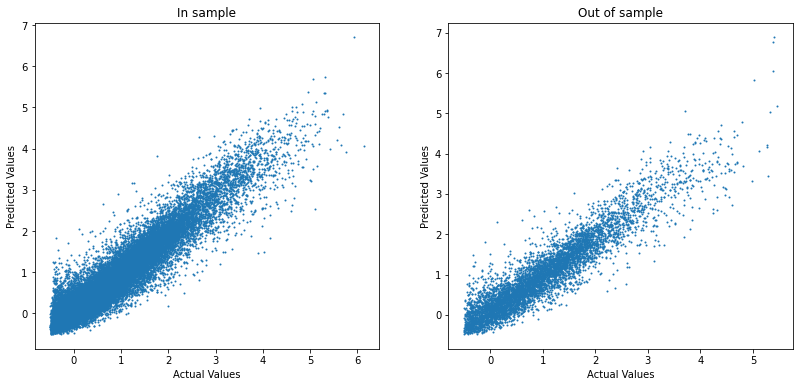

In [ ]:
yActualTrain, yActualVal, yPredTrain, yPredVal = getTrainAndValOutputs( icModel, icTrainLoader, icValLoader)
plotPredictions(yActualTrain, yActualVal, yPredTrain, yPredVal)

In [ ]:
tMeans = [0.15630499,0.54902774,0.04021916,0.53220327,1.57032268]

tStds = [0.13603969,0.30926215,0.01731955,0.27354582,0.84257395]

minC = -1.0754482995211179
minOutput = -1.51383233733901
μOutput = 0.6039890110123125
σOutput = 0.3986395125288202


class fBMDatasetInference(Dataset):
    
    def __init__(self, testData ):
        self.data = testData[['C','S','r','K','τ']]
        self.data = (self.data - tMeans)/tStds
        self.data['C'] = self.data['C'] - minC - 0.5

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index, :]
        X = torch.from_numpy(item.values).float()
        return X, X

In [ ]:
def createTestData( dataSize, H, σ ):
  ''' Create <dataSize> number of fBSM entries in the <dataFile> '''
  i, data = 0, np.zeros((dataSize,7))
  while i < dataSize:
    SbyK,K,r,τ = randSbyK(),randK(),randR(),randτ()
    S = SbyK*K
    C = Cf(S,K,r,τ,σ,H)
    if C < 0.001: continue
    data[i,:] = [S,K,r,τ,σ,H,C]
    i += 1
  return pd.DataFrame(data, columns=columns)

testLength, H, σ = 1000, 0.6, 0.1
testData = createTestData(testLength, H, σ )

In [ ]:
def infer( model, loader, length ):
  lnT, predictions,cost = np.zeros(length), np.zeros(length), np.zeros(length)
  with torch.no_grad():
    model.eval()
    i = 0
    for Xs, _ in loader:
      Xs = Xs.to(device=device)
      predictions[i:i+len(Xs)] = model(Xs).numpy().flatten()
      lnT[i:i+len(Xs)] = Xs[:,-1]
      cost[i:i+len(Xs)] = Xs[:,0]
      i += len(Xs)
  return lnT, predictions

In [ ]:
marketData = fBMDatasetInference(testData)
mdLoader = torch.utils.data.DataLoader(marketData, 1, shuffle= False)

In [ ]:
timePeriod, predictions = infer(iModel, mdLoader, testLength)
Y = (predictions+minOutput+0.5)*σOutput + μOutput
X = timePeriod*tStds[-1] + tMeans[-1]
regression = LinearRegression().fit(np.log(X).reshape(-1,1),np.log(Y))
print(np.exp(regression.intercept_))
print(regression.coef_[0])

0.12705353047517406
0.4207223636472288


In [ ]:
timePeriod, predictions = infer(icModel, mdLoader, testLength)
cY = (predictions+minOutput+0.5)*σOutput + μOutput
cX = timePeriod*tStds[-1] + tMeans[-1]
regression = LinearRegression().fit(np.log(cX).reshape(-1,1),np.log(cY))
print(np.exp(regression.intercept_))
print(regression.coef_[0])

0.1380556098971382
0.4158582836342546
